# Tensorflow SOM

In [1]:
import tensorflow as tf
from tensorflow.python.tools import inspect_checkpoint as chkp
from tensorflow.python.platform import gfile
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
# boilerplate code
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
import random
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
import somoclu
from sklearn.metrics.pairwise import pairwise_distances
# import deep_som as ds
import time
import matplotlib.cm as cm
from pathlib import Path
import pprint, pickle
import neural_map as nm
import utils

np.set_printoptions(precision=3)

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1 - Load dataset

In [2]:
with open('cnn_200_training.pickle', 'rb') as f:
    train = pickle.load(f)
train_x = train["input"]
train_y = train["out"]

In [3]:
print(train_y[:10])
print(train_x.shape)

['yes', 'seven', 'one', 'no', 'up', 'zero', 'wow', 'cat', 'no', 'nine']
(10000, 200)


In [4]:
print("train data range: [{}; {}]". format(np.min(train_x), np.max(train_x)))

train data range: [-18.562110900878906; 19.811689376831055]


In [5]:
print("0th sample:", train_x[0])

0th sample: [ 0.802 -0.375 -6.15   2.013 -1.093  0.735 -0.923 -1.435  0.487 -3.096
  0.709  0.648  1.106 -1.395 -2.157 -0.641 -0.298 -1.152 -4.341 -0.693
  2.327  0.959 -1.433 -1.316  2.544  0.365  1.6   -2.178  0.258 -3.569
  0.292  3.025 -4.093 -0.203  0.652  1.132  0.472  0.027  0.287  2.344
 -0.656  2.003 -0.423 -2.967 -1.493 -0.104  1.735  0.557  1.213  2.763
  0.314 -1.073 -0.414  5.3   -1.431  1.139 -1.432 -3.449  3.112 -2.521
  0.588 -0.205 -0.903 -1.195 -1.907  3.117 -3.541 -0.766  0.453 -2.024
  0.545 -1.913  3.354  1.086  3.74   1.565  0.907  1.226 -0.21   1.985
 -2.74   0.964 -3.166  2.486 -2.785  3.731 -1.202  2.338  1.691  1.005
  0.297  1.649 -2.009 -2.414 -3.38  -0.404  2.422  1.526  0.515  0.625
  3.057  0.345  3.713  2.324 -2.266 -0.2    4.999  1.634 -0.752  0.496
 -1.512 -0.557  2.192 -1.611 -0.881  0.87   0.773 -4.511 -3.582 -3.066
  0.577  6.431  2.778  2.851  2.008 -1.394 -0.763  4.023 -4.444 -1.397
 -0.251  0.945 -0.524  2.427  0.304  2.586  1.756  1.451  2.276  

### normalize data

In [6]:
train_x_sq = np.multiply(train_x, train_x)
train_x_norm = np.sqrt(np.sum(train_x_sq, axis=1))
print(train_x_norm.shape)
train_x = np.divide(train_x, train_x_norm[:, None])
# train_x = (train_x - np.min(train_x, axis=0)) / (np.max(train_x, axis=0) - np.min(train_x, axis=0))

print("train data range: [{}; {}]". format(np.min(train_x), np.max(train_x)))

print("0th sample:", train_x[0])

(10000,)
train data range: [-0.2982984185218811; 0.30229073762893677]
0th sample: [ 0.025 -0.012 -0.195  0.064 -0.035  0.023 -0.029 -0.045  0.015 -0.098
  0.022  0.021  0.035 -0.044 -0.068 -0.02  -0.009 -0.036 -0.137 -0.022
  0.074  0.03  -0.045 -0.042  0.08   0.012  0.051 -0.069  0.008 -0.113
  0.009  0.096 -0.129 -0.006  0.021  0.036  0.015  0.001  0.009  0.074
 -0.021  0.063 -0.013 -0.094 -0.047 -0.003  0.055  0.018  0.038  0.087
  0.01  -0.034 -0.013  0.168 -0.045  0.036 -0.045 -0.109  0.098 -0.08
  0.019 -0.006 -0.029 -0.038 -0.06   0.099 -0.112 -0.024  0.014 -0.064
  0.017 -0.061  0.106  0.034  0.118  0.05   0.029  0.039 -0.007  0.063
 -0.087  0.031 -0.1    0.079 -0.088  0.118 -0.038  0.074  0.054  0.032
  0.009  0.052 -0.064 -0.076 -0.107 -0.013  0.077  0.048  0.016  0.02
  0.097  0.011  0.117  0.074 -0.072 -0.006  0.158  0.052 -0.024  0.016
 -0.048 -0.018  0.069 -0.051 -0.028  0.028  0.024 -0.143 -0.113 -0.097
  0.018  0.203  0.088  0.09   0.064 -0.044 -0.024  0.127 -0.141 -0.0

### split test and train data

In [7]:
test_num = 1000

test_x = np.array(train_x[:test_num])
test_y = np.array(train_y[:test_num])

## 2 - Create SOM

In [8]:
input_shape = (200, 1)
n_rows = 100
n_cols = 100
name = "som_0"
sess = tf.Session()
with sess.as_default():
    som = nm.NeuralSOM(input_shape, n_rows, n_cols, name)
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

## 3 - Run untrained SOM on test data and plot bmus

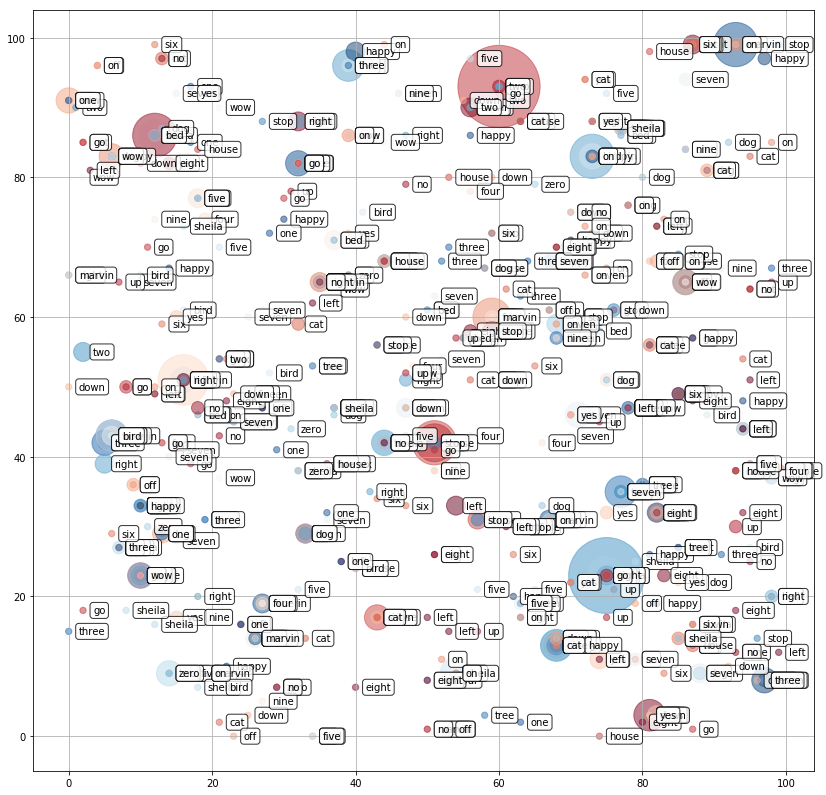

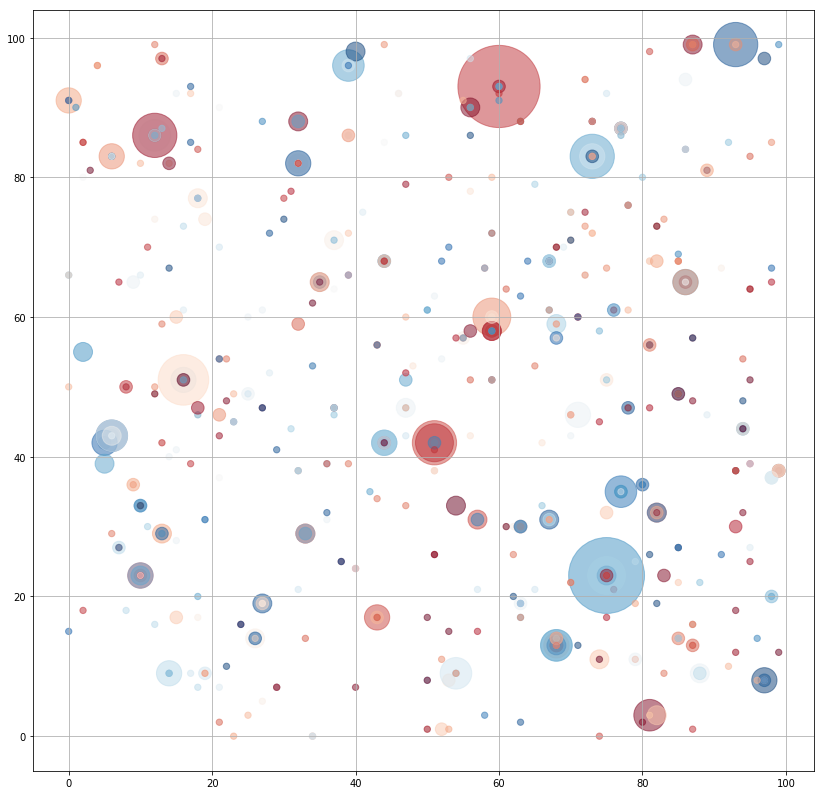

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
with sess.as_default():
    bmus = som.get_bmus(test_x)
utils.view_bmus(bmus, test_y, default_marker_size=40, annotate=True)
utils.view_bmus(bmus, test_y, default_marker_size=40, annotate=False)

## 4 - Train SOM and save it

In [10]:
with sess.as_default():
    som.train(train_x, num_epochs=20, neighbour_sigma_start=40, neighbour_sigma_end=1,
              learning_rate_start=0.1, learning_rate_end=0.01, verbose=2)
    saver = tf.train.Saver()
    saver.save(sess, "./logs/"+name)


epoch: 1 out of 20
...processing 9900 out of 10000
epoch: 2 out of 20
...processing 9900 out of 10000
epoch: 3 out of 20
...processing 9900 out of 10000
epoch: 4 out of 20
...processing 9900 out of 10000
epoch: 5 out of 20
...processing 9900 out of 10000
epoch: 6 out of 20
...processing 9900 out of 10000
epoch: 7 out of 20
...processing 9900 out of 10000
epoch: 8 out of 20
...processing 9900 out of 10000
epoch: 9 out of 20
...processing 9900 out of 10000
epoch: 10 out of 20
...processing 9900 out of 10000
epoch: 11 out of 20
...processing 9900 out of 10000
epoch: 12 out of 20
...processing 9900 out of 10000
epoch: 13 out of 20
...processing 9900 out of 10000
epoch: 14 out of 20
...processing 9900 out of 10000
epoch: 15 out of 20
...processing 9900 out of 10000
epoch: 16 out of 20
...processing 9900 out of 10000
epoch: 17 out of 20
...processing 9900 out of 10000
epoch: 18 out of 20
...processing 9900 out of 10000
epoch: 19 out of 20
...processing 9900 out of 10000
epoch: 20 out of 20


## 5 - Run trained SOM on test data and plot bmus

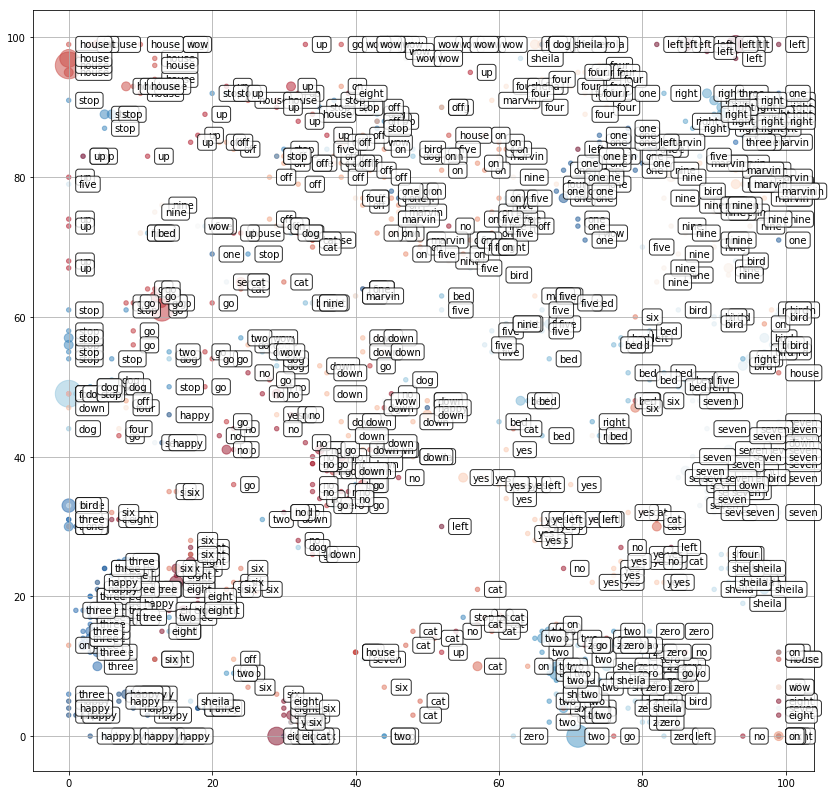

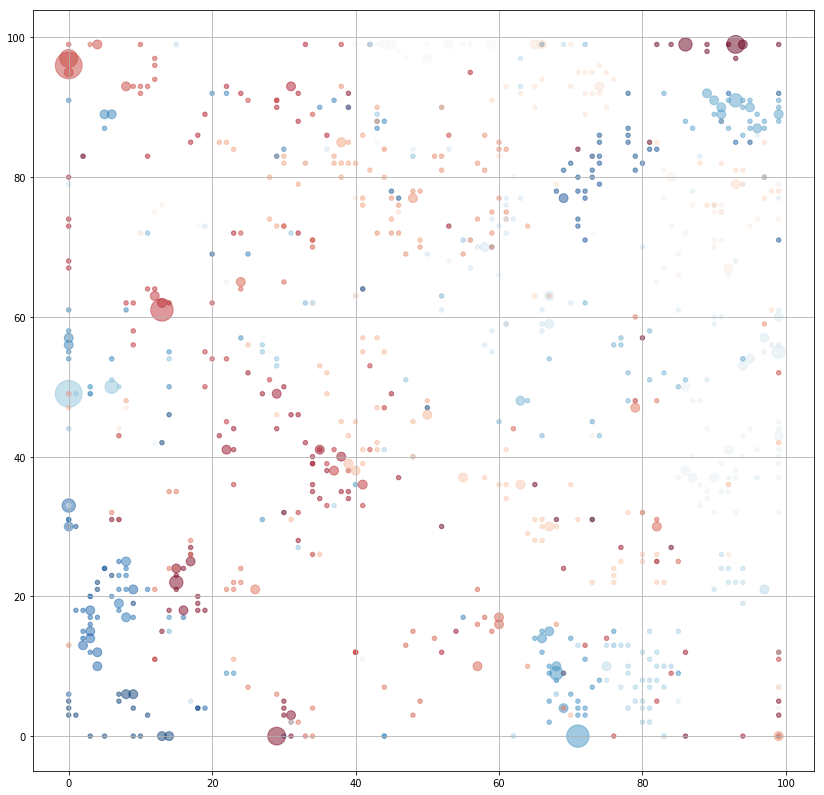

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [11]:
with sess.as_default():
    bmus = som.get_bmus(test_x)
    
utils.view_bmus(bmus, test_y, annotate=True)
utils.view_bmus(bmus, test_y)


epoch: 1 out of 5
...processing 9900 out of 10000
epoch: 2 out of 5
...processing 9900 out of 10000
epoch: 3 out of 5
...processing 9900 out of 10000
epoch: 4 out of 5
...processing 9900 out of 10000
epoch: 5 out of 5
...processing 9900 out of 10000
learning finished...


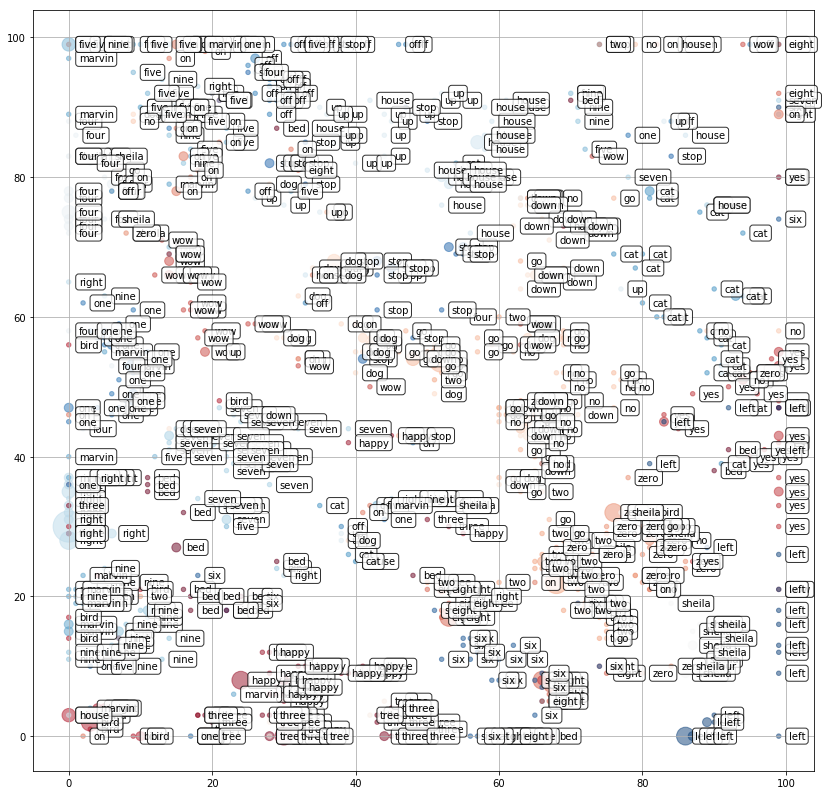

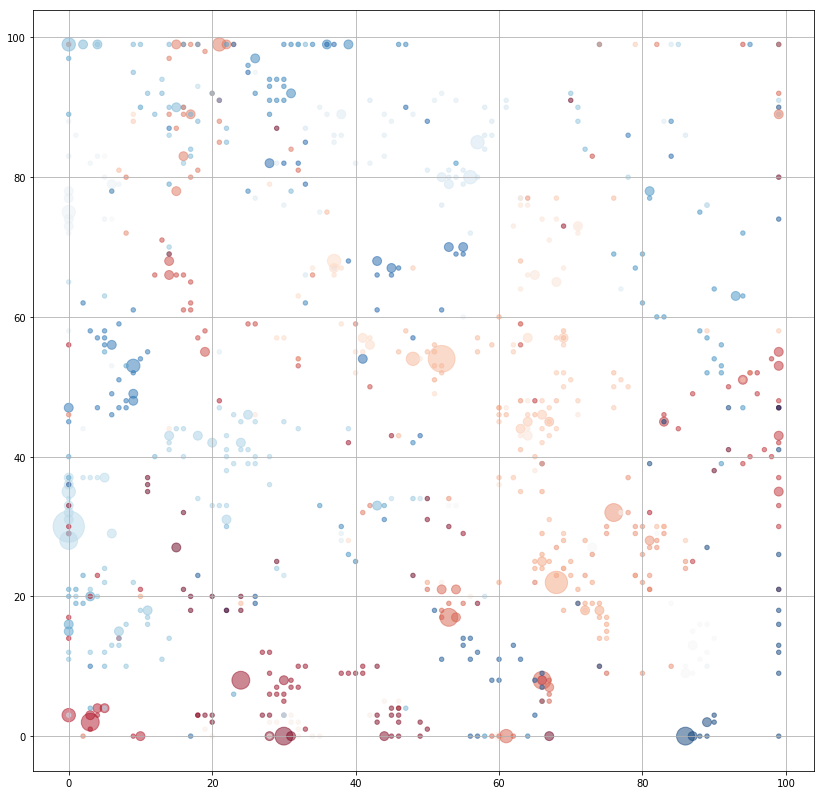

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [12]:
with sess.as_default():
    som.train(train_x, num_epochs=5, neighbour_sigma_start=5, neighbour_sigma_end=1,
              learning_rate_start=0.05, learning_rate_end=0.01, verbose=2)
    saver = tf.train.Saver()
    saver.save(sess, "./logs/"+name+"10")
with sess.as_default():
    bmus = som.get_bmus(test_x)
    
utils.view_bmus(bmus, test_y, annotate=True)
utils.view_bmus(bmus, test_y)